#### Set conditions for the plots and import the relevant packages

In [1]:
%matplotlib inline

# plot configuration
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use("ggplot")

matplotlib.rcParams['figure.figsize']  = (7.0,5.0)

In [2]:
import numpy as np
from scipy import special, stats
import sobol_seq
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from openpyxl import load_workbook
import types
import pkg_resources

### Check the packages requirements for reproducibility

In [3]:
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

statsmodels==0.11.0
seaborn==0.10.0
scipy==1.4.1
pandas==0.25.3
numpy==1.18.1
matplotlib==3.1.3


### Define base functions and the sample quasi-random distribution 

In [4]:
def decreasePaceSilver2050(silverCell):
    return - 1/(2050-2017) * np.log(silverCell/ITRPV2018silverCell2017)

def mu(x):
    return np.mean(x)

def sigma(x):
    return np.std(x)

In [5]:
sampleTot = sobol_seq.i4_sobol_generate(13,1000*2**13).T

### Current use of silver paste (mg/cell) - year 2017 - source ITRPV 2018

In [6]:
ITRPV2018silverCell2017 = 100
ITRPVsilverCell2028 = 50 
ITRPV2018decreasePace= - 1/(2028-2017) * np.log(ITRPVsilverCell2028/ITRPV2018silverCell2017)

### Silver cell decrease pace - distribution generated on the basis of the experts consultation

In [7]:
silverCell2050DecreasePace = np.array([ITRPV2018decreasePace, ITRPV2018decreasePace, \
decreasePaceSilver2050(ITRPV2018silverCell2017*0.01), decreasePaceSilver2050(ITRPV2018silverCell2017*0.01),\
decreasePaceSilver2050(10), decreasePaceSilver2050(15),decreasePaceSilver2050((20+10)/2), 0.05])

### PV Cell Efficiency growth up to the year 2050 (W/cell)

In [8]:
PVCellEfficiency2017 = 4.27

PVCellEfficiency2050 = 6.1 

PVCellEfficiencyIncreasePace = 1/(2050-2017) * np.log(PVCellEfficiency2050/PVCellEfficiency2017)

### Current expansion of PV power capacity (GW) - year 2017

In [9]:
PVPC2017 = 99
CrystallineSiliconShare = 0.9
IEA2050 = 4670
Greenpeace2050 = 9295
Fraunhofer2050 = 30700
CPVPC2017 = 402

IEA2050_CrystallineSiliconShare = IEA2050 * CrystallineSiliconShare
Greenpeace2050_CrystallineSiliconShare = Greenpeace2050 * CrystallineSiliconShare
Fraunhofer2050_CrystallineSiliconShare = Fraunhofer2050 * CrystallineSiliconShare
PVPC2017_CrystallineSiliconShare = PVPC2017 * CrystallineSiliconShare

PVPC2050IncreasePace = np.array([0.025, 0.112, 0.061])

### Non-industrial + Industrial Non-PV

In [10]:
wb = load_workbook(filename='Datum.xlsx', read_only=True)

ws = wb['World_silver_survey_2018']

# Read the cell values into a list of lists
data_rows = []
for row in ws['B26':'M26']:
    data_cols = []
    for cell in row:
        data_cols.append(cell.value)
    data_rows.append(data_cols)

otherAg = pd.DataFrame(data_rows).T
otherAg.index=[y for y in range(2006,2018)]
# A negative correlation between the two variables has been confirmed by checking the sign of the anti-diagonal matrix

### Yearly extraction capacity

In [11]:
Extraction = pd.read_excel('Datum.xlsx',sheet_name='USGS',index_col=0)
Extraction.columns = ['Global Production']

### Generate the parameters distribution 

In [12]:
silverCellDistribution2 = pd.DataFrame(sigma(silverCell2050DecreasePace)*2**0.5*special.erfinv(2*(sampleTot[0][:2**13]*
0.5*(special.erf((silverCell2050DecreasePace.max()-mu(silverCell2050DecreasePace))/(sigma(silverCell2050DecreasePace)*2**0.5))-
special.erf(-mu(silverCell2050DecreasePace)/(sigma(silverCell2050DecreasePace)*2**0.5)))+0.5*
special.erf(-mu(silverCell2050DecreasePace)/(sigma(silverCell2050DecreasePace)*2**0.5))))+mu(silverCell2050DecreasePace))

silverCellDistribution2B = pd.DataFrame(sigma(silverCell2050DecreasePace)*2**0.5*special.erfinv(2*(sampleTot[6][:2**13]*
0.5*(special.erf((silverCell2050DecreasePace.max()-mu(silverCell2050DecreasePace))/(sigma(silverCell2050DecreasePace)*2**0.5))-
special.erf(-mu(silverCell2050DecreasePace)/(sigma(silverCell2050DecreasePace)*2**0.5)))+0.5*
special.erf(-mu(silverCell2050DecreasePace)/(sigma(silverCell2050DecreasePace)*2**0.5))))+mu(silverCell2050DecreasePace))

PVPC2050IncreasePaceDist = pd.DataFrame(pd.DataFrame(sigma(PVPC2050IncreasePace)*2**0.5*special.erfinv(2*(sampleTot[1][:2**13]*
0.5*(special.erf((PVPC2050IncreasePace.max()-mu(PVPC2050IncreasePace))/(sigma(PVPC2050IncreasePace)*2**0.5))-
special.erf(-mu(PVPC2050IncreasePace)/(sigma(PVPC2050IncreasePace)*2**0.5)))+0.5*
special.erf(-mu(PVPC2050IncreasePace)/(sigma(PVPC2050IncreasePace)*2**0.5))))+mu(PVPC2050IncreasePace)))

PVPC2050IncreasePaceDistB = pd.DataFrame(pd.DataFrame(sigma(PVPC2050IncreasePace)*2**0.5*special.erfinv(2*(sampleTot[7][:2**13]*
0.5*(special.erf((PVPC2050IncreasePace.max()-mu(PVPC2050IncreasePace))/(sigma(PVPC2050IncreasePace)*2**0.5))-
special.erf(-mu(PVPC2050IncreasePace)/(sigma(PVPC2050IncreasePace)*2**0.5)))+0.5*
special.erf(-mu(PVPC2050IncreasePace)/(sigma(PVPC2050IncreasePace)*2**0.5))))+mu(PVPC2050IncreasePace)))

Noise = pd.DataFrame(sigma(sampleTot[2][:2**13])*2**0.5*special.erfinv(2*sampleTot[2][:2**13]-1))
NoiseB = pd.DataFrame(sigma(sampleTot[8][:2**13])*2**0.5*special.erfinv(2*sampleTot[8][:2**13]-1))

# Resources and reserves
distributionSilverReserveResource = pd.DataFrame(sampleTot[4][:2**13]*(4000-530)+530)
distributionSilverReserveResourceB = pd.DataFrame(sampleTot[10][:2**13]*(4000-530)+530)

### Fit the non-PV Silver use and Silver extraction models

In [13]:
model = ARIMA((otherAg.reset_index(drop=True)+Noise.iloc[:len(otherAg)])[0], order=(0, 1, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.predict(len(otherAg), 44, typ='levels')
yhat.index = yhat.index + 2006
forecast, stderr, conf = model_fit.forecast(33)

modelB = ARIMA((otherAg.reset_index(drop=True)+NoiseB.iloc[:len(otherAg)])[0], order=(0, 1, 1))
model_fitB = modelB.fit(disp=False)
# make prediction
yhatB = model_fitB.predict(len(otherAg), 44, typ='levels')
yhatB.index = yhat.index
forecastB, stderrB, confB = model_fitB.forecast(33)

model2 = ARIMA(((Extraction['Global Production'].reset_index(drop=True)+Noise.iloc[:len(Extraction)].T).T)[0],
               order=(0, 2, 1))
model_fit2 = model2.fit(disp=False)
# make prediction
yhat2 = model_fit2.predict(len(Extraction), 105, typ='levels')
yhat2.index = yhat2.index+1946
forecast2, stderr2, conf2 = model_fit2.forecast(33)

model2B = ARIMA(((Extraction['Global Production'].reset_index(drop=True)+Noise.iloc[:len(Extraction)].T).T)[0], 
                 order=(0, 2, 1))
model_fit2B = model2B.fit(disp=False)
# make prediction
yhat2B = model_fit2B.predict(len(Extraction), 105, typ='levels')
yhat2B.index = yhat2B.index+1946
forecast2B, stderr2B, conf2B = model_fit2B.forecast(33)

### Generate the distributions for non-PV Silver use and Silver extraction

In [14]:
otherAgDist = pd.DataFrame([((forecast[i]-conf[i][0])/1.96)*2**0.5*special.erfinv(sampleTot[3][:2**13]*
(1-special.erf(-forecast[i]/(((forecast[i]-conf[i][0])/1.96)*2**0.5)))+special.erf(-forecast[i]/
(((forecast[i]-conf[i][0])/1.96)*2**0.5)))+forecast[i] for i in range(len(forecast))],index=[i for i in range(2018,2051)])

otherAgDistB = pd.DataFrame([((forecastB[i]-confB[i][0])/1.96)*2**0.5*special.erfinv(sampleTot[9][:2**13]*
(1-special.erf(-forecastB[i]/(((forecastB[i]-confB[i][0])/1.96)*2**0.5)))+special.erf(-forecastB[i]/
(((forecastB[i]-confB[i][0])/1.96)*2**0.5)))+forecastB[i] for i in range(len(forecastB))],index=[i for i in range(2018,2051)])

ExtractionDist = pd.DataFrame([((forecast2[i]-conf2[i][0])/1.96)*2**0.5*special.erfinv(sampleTot[5][:2**13]*
(1-special.erf(-forecast2[i]/(((forecast2[i]-conf2[i][0])/1.96)*2**0.5)))+special.erf(-forecast2[i]/
(((forecast2[i]-conf2[i][0])/1.96)*2**0.5)))+forecast2[i] for i in range(len(forecast2))],index = otherAgDist.index)

ExtractionDistB = pd.DataFrame([((forecast2B[i]-conf2B[i][0])/1.96)*2**0.5*special.erfinv(sampleTot[11][:2**13]*
(1-special.erf(-forecast2B[i]/(((forecast2B[i]-conf2B[i][0])/1.96)*2**0.5)))+special.erf(-forecast2B[i]/
(((forecast2B[i]-conf2B[i][0])/1.96)*2**0.5)))+forecast2B[i] for i in range(len(forecast2B))],index = otherAgDistB.index)

#### Assess PV silver demand, Yearly Silver demand (and its derivative), Cumulative Silver demand along with viability and feasibility

In [15]:
# Generation of the yearly silver output (1,000 metric tonnes)
PVDemand = pd.concat([(ITRPV2018silverCell2017 * np.exp(-silverCellDistribution2*i1)/(PVCellEfficiency2017 * 
np.exp(PVCellEfficiencyIncreasePace*i1)))* PVPC2017 * CrystallineSiliconShare * np.exp(PVPC2050IncreasePaceDist*i1)/
1000 for i1 in range(1,34)],axis=1)

PVDemand.columns = [i2 for i2 in range(2018,2051)]

PVDemandAB1 = pd.concat([(ITRPV2018silverCell2017 * np.exp(-silverCellDistribution2B*i1)/(PVCellEfficiency2017 * 
np.exp(PVCellEfficiencyIncreasePace*i1)))* PVPC2017 * CrystallineSiliconShare * np.exp(PVPC2050IncreasePaceDist*i1)/
1000 for i1 in range(1,34)],axis=1)

PVDemandAB1.columns = [i2 for i2 in range(2018,2051)]

PVDemandAB2 = pd.concat([(ITRPV2018silverCell2017 * np.exp(-silverCellDistribution2*i1)/(PVCellEfficiency2017 * 
np.exp(PVCellEfficiencyIncreasePace*i1)))* PVPC2017 * CrystallineSiliconShare * np.exp(PVPC2050IncreasePaceDistB*i1)/
1000 for i1 in range(1,34)],axis=1)

PVDemandAB2.columns = [i2 for i2 in range(2018,2051)]

PVDemandB = pd.concat([(ITRPV2018silverCell2017 * np.exp(-silverCellDistribution2B*i1)/(PVCellEfficiency2017 * 
np.exp(PVCellEfficiencyIncreasePace*i1)))* PVPC2017 * CrystallineSiliconShare * np.exp(PVPC2050IncreasePaceDistB*i1)/
1000 for i1 in range(1,34)],axis=1)

PVDemandB.columns = [i2 for i2 in range(2018,2051)]

# Generation of the cumulative silver output (1,000 metric tonnes)
yearlySilver = PVDemand+otherAgDist.T
yearlySilverAB1 = PVDemandAB1+otherAgDist.T
yearlySilverAB2 = PVDemandAB2+otherAgDist.T
yearlySilverAB3 = PVDemand+otherAgDistB.T
yearlySilverB = PVDemandB+otherAgDistB.T

CumulativeSilver = yearlySilver.cumsum(axis=1)
CumulativeSilverAB1 = yearlySilverAB1.cumsum(axis=1)
CumulativeSilverAB2 = yearlySilverAB2.cumsum(axis=1)
CumulativeSilverAB3 = yearlySilverAB3.cumsum(axis=1)
CumulativeSilverB = yearlySilverB.cumsum(axis=1)

# Derivative Yearly Silver Demand
derivativeYearlySilver = yearlySilver.diff(axis=1)

# Yearly Delta (viability, technological constraint)

silverDelta = ExtractionDist.T - 0.8*yearlySilver

# Cumulative Delta (feasibility, biophysical constraint)

Difference = distributionSilverReserveResource.values-0.8*CumulativeSilver
DifferenceAB1 = distributionSilverReserveResource.values-0.8*CumulativeSilverAB1
DifferenceAB2 = distributionSilverReserveResource.values-0.8*CumulativeSilverAB2
DifferenceAB3 = distributionSilverReserveResource.values-0.8*CumulativeSilverAB3
DifferenceAB4 = distributionSilverReserveResourceB.values-0.8*CumulativeSilver
DifferenceB = distributionSilverReserveResourceB.values-0.8*CumulativeSilverB

### Let's now evaluate the scatter plot trends over time

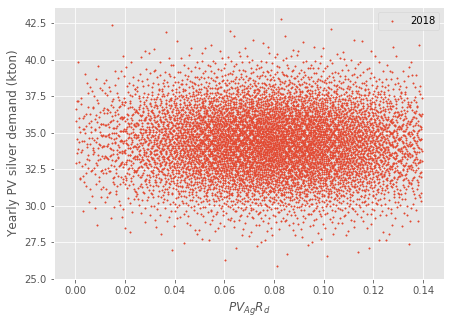

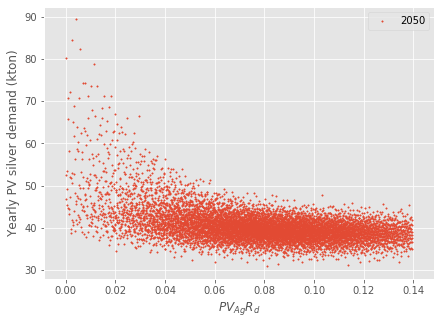

In [19]:
for col in yearlySilver.iloc[:, list(range(1)) + [-1]]:
    plt.scatter(silverCellDistribution2, yearlySilver[col], s = 2, label = str(col))
    plt.xlabel('$PV_{Ag}R_{d}$')
    plt.ylabel('Yearly PV silver demand (kton)')
    plt.legend()
    plt.show()

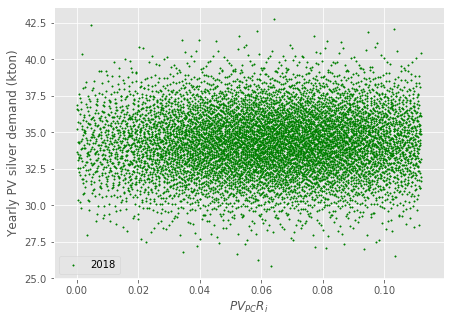

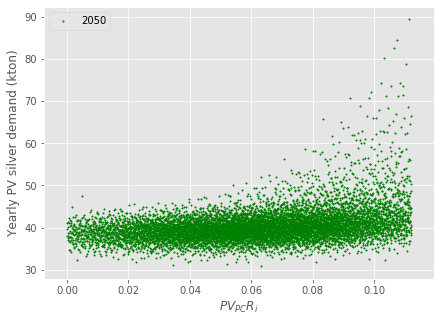

In [20]:
for col in yearlySilver.iloc[:, list(range(1)) + [-1]]:
    plt.scatter(PVPC2050IncreasePaceDist, yearlySilver[col], c = 'g',s = 2, label = str(col))
    plt.xlabel('$PV_{PC}R_{i}$')
    plt.ylabel('Yearly PV silver demand (kton)')
    plt.legend()
    plt.show()

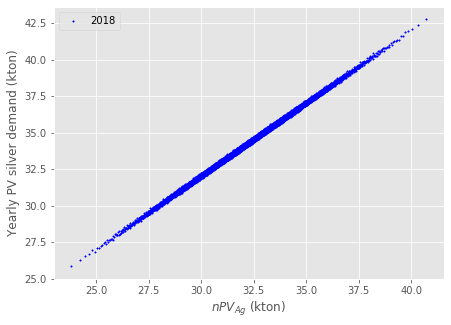

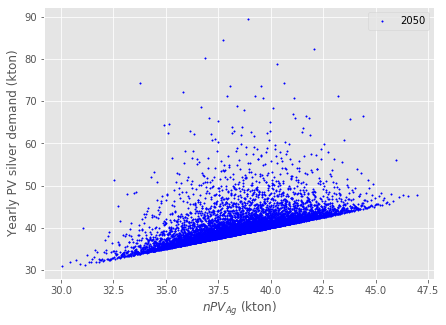

In [21]:
for col in yearlySilver.iloc[:, list(range(1)) + [-1]]:
    plt.scatter(otherAgDist.loc[col], yearlySilver[col], c = 'b',s = 2, label = str(col))
    plt.xlabel('$nPV_{Ag}$ (kton)')
    plt.ylabel('Yearly PV silver demand (kton)')
    plt.legend()
    plt.show()